# Задача 5

Импорт модулей

In [1]:
import numpy as np
from numpy import pi, sin, cos, sqrt
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
matplotlib.rcParams.update({'font.size': 20})

from scipy.misc import derivative
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import numdifftools as nd

from tqdm import tqdm
import logging
import traceback
import os

try:
  from google.colab import drive
  drive.mount('/content/drive')
  IN_COLAB = True
except:
  IN_COLAB = False

Чтение файлов

In [2]:
if IN_COLAB:
  NRLMSIS_day = np.loadtxt('/content/drive/MyDrive/exam_rrv/NRLMSIS_day.txt', skiprows=1)
  NRLMSIS_night = np.loadtxt('/content/drive/MyDrive/exam_rrv/NRLMSIS_night.txt', skiprows=1)
  IRI_day = np.loadtxt('/content/drive/MyDrive/exam_rrv/IRI2016_day.txt', skiprows=35)
  IRI_night = np.loadtxt('/content/drive/MyDrive/exam_rrv/IRI2016_night.txt', skiprows=35)
else:
  NRLMSIS_day = np.loadtxt('NRLMSIS_day.txt', skiprows=1)
  NRLMSIS_night = np.loadtxt('NRLMSIS_night.txt', skiprows=1)
  IRI_day = np.loadtxt('IRI2016_day.txt', skiprows=35)
  IRI_night = np.loadtxt('IRI2016_night.txt', skiprows=35)

Создание массивов с данными из модели ионосферы

In [3]:
N_e_day = np.array([item[1] for item in IRI_day], dtype=np.longdouble)
N_e_night = np.array([item[1] for item in IRI_night], dtype=np.longdouble)
z = np.array([item[0] for item in IRI_day], dtype=int) * 1000

Чистка данных

In [4]:
mask_day = N_e_day != -1
mask_night = N_e_night != -1

N_e_day = N_e_day[mask_day]
N_e_night = N_e_night[mask_night]

z_day = z[mask_day]
z_night = z[mask_night]

Блок с константами

In [5]:
date = dt.datetime(int(NRLMSIS_day[0][0]), int(NRLMSIS_day[0][1]), int(NRLMSIS_day[0][2]), int(NRLMSIS_day[0][4]))

e_charge = 4.8e-10
mass_e = 9.1094e-28

Блок с формулами для расчетов и инициализацией переменных

In [6]:
def init_var(freq, mode):
        
    # обозначение переменных в зависимости от времени суток
    if mode == 'night':
        z, N_e = z_night, N_e_night
        layers = [15, 50, 130, 250, 450]
    elif mode == 'day':
        z, N_e = z_day, N_e_day
        layers = [15, 50, 90, 130, 250, 450]
    
    # пересчет обычной частоты в циклическую
    omega = 2 * pi * (freq * 1e6)
    # считаем плазменную частоту в СГС
    omega_plasm = sqrt((4 * pi * (e_charge ** 2) * N_e / mass_e))
    # считаем квадрат показателя преломления
    n_quad = 1 - ((omega_plasm**2)/(omega ** 2))
    # берем корень, сохраняя комплексную часть
    n = sqrt(n_quad + 0j)
    # сразу создаем интерполяцию значений для показателя преломления
    interpol_n = interp1d(z, n, kind = 'cubic')
    # отдельная переменная для создания подложки
    n_for_graph = np.pad(sqrt(abs(n_quad)), (1000 - len(n), 0), mode='constant', constant_values=1)

    return omega, omega_plasm, n_quad, n, interpol_n, n_for_graph, z, N_e, layers, freq, mode

In [7]:
def ploting_n_distibution(n, N_e, freq, mode):
    fig, ax = plt.subplots(figsize=(25, 12))
    ax.plot(z/1000, n.real, label='$Re(n)$', color='r', linewidth=5, zorder = 10)
    if np.sum(n.imag) != 0: 
        ax.plot(z/1000, n.imag, label='$Im(n)$', color='g', linewidth=5, zorder = 10)
    ax.set_ylabel('$n$')
    ax.set_xlabel('$Z$, км')
    ax.set_ylim(-0.005)
    ax.grid(True, color='r')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.legend()
        
    ax2 = ax.twinx()
    ax2.bar(z/1000, N_e, zorder = 5, color='cornflowerblue', label = 'Концентрация электронов', width = 0.45)
    ax2.set_ylabel('$N_e, {см}^{-3}$')
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(15000))
    ax2.grid(which='major', color = 'dimgrey', linestyle = ':', linewidth = 0.5)
    plt.legend(loc = 'center right')
    plt.tight_layout()
    plt.savefig(f'n, {freq}, {mode}.png')

Интегрирование

In [8]:
def dp_zdt(z, n):
    try:
        # считаем прозводную
        d = 0.5 * derivative(lambda z: n(z)**2, z, dx=1, n=1)
    except:
        # если не получилось, значит нет данных, потому что в слое мало электронов
        # следовательно, n = 1 и производная равна 0
        d = 0
    return d

# система ДУ
def ode(t, p, n, p_x, p_y): 
    # распаковка
    x, y, z, p_z = p
    # если траектория ушла под землю, зануляем координаты
    if z < 0: p_x, p_y, p_z = 0, 0, 0
    return [p_x, p_y, p_z, dp_zdt(z, n)]

def solve(n, z0, teta_0, phi_0, t):
    p_x0 = sin(teta_0) * cos(phi_0)
    p_y0 = sin(teta_0) * sin(phi_0)
    p_z0 = cos(teta_0)
    
    #print(p_x0, p_y0, p_z0)
    p0 = [0, 0, z0, p_z0]
    sol = solve_ivp(ode, [t[0], t[-1]], p0, args=(n, p_x0, p_y0), dense_output=True, max_step = 1000)
    return sol.sol(t)

In [9]:
def calculating(thetas, freq, interpol_n, n_for_graph, layers, mode, colors = False, background = True, layers_mode = False):
    
    x_max_on_line = []
    z_max_on_line = []

    fig = plt.figure(figsize=(25, 10))
    ax = fig.gca()
    
    colors_arr = plt.cm.rainbow(thetas)[::-1]

    for index, theta in enumerate(tqdm(thetas, ncols=100)):
        t = np.linspace(0, 5000e3, 2**12) # читать как оптический путь
        x, y, z, p_z = solve(interpol_n, 0, theta, 0, t)
        x_max_on_line.append(int(x.max()/1e3))
        z_max_on_line.append(int(z.max()/1e3))
        if colors != False:
            plt.plot(x/1e3, z/1e3, linewidth=5, c = colors_arr[index])
        else:
            plt.plot(x/1e3, z/1e3, linewidth=5)

    z_max, x_max = np.array(z_max_on_line).max(), np.array(x_max_on_line).max()

    if background == True:
        plt.imshow(np.tile(n_for_graph.reshape(-1, 1)[0:z_max + 15], x_max), origin='lower', cmap=plt.cm.Wistia.reversed(), aspect='auto', alpha=0.4)
        
    if layers_mode == True:
        for index, layer in enumerate(tqdm(layers, ncols=150)):
            plt.plot((0, x_max), (layer, layer), c = 'k', linestyle = '--', linewidth = 0.5)
            
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    plt.ylim(0, z_max + 15) if z_max < 385 else plt.ylim(0, 400)
    plt.xlim(0, x_max) if x_max < 1000 else plt.xlim(0, 1000)
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f'ray, {freq}, {mode}.png')

In [10]:
import concurrent.futures
from sys import platform
import logging

# logging.getLogger("concurrent.futures").setLevel(logging.ERROR)

def multi_calculating(thetas, freq, interpol_n, n_for_graph, layers, mode, colors = False, background = True, layers_mode = False):
    
    x_max_on_line = []
    z_max_on_line = []

    fig = plt.figure(figsize=(25, 10))
    ax = fig.gca()
    
    t = np.linspace(0, 5000e3, 2**12) # читать как оптический путь
    colors_arr = plt.cm.rainbow(thetas)[::-1]
    
    if platform == "win32":
        with concurrent.futures.ThreadPoolExecutor(max_workers=os.cpu_count()-1) as executor:
            futures = {executor.submit(solve, interpol_n, 0, theta, 0, t): i for i, theta in enumerate(thetas)}
            
    elif platform == "linux":
        with concurrent.futures.ProcessPoolExecutor(max_workers=os.cpu_count()-1) as executor:
            futures = {executor.submit(solve, interpol_n, 0, theta, 0, t): i for i, theta in enumerate(thetas)}
        
    for future in concurrent.futures.as_completed(futures):
        
        index = futures[future]
        
        try:
    
            x, y, z, p_z = future.result()
            
            x_max_on_line.append(int(x.max()/1e3))
            z_max_on_line.append(int(z.max()/1e3))
            
            if colors != False:
                plt.plot(x/1e3, z/1e3, linewidth=5, c = colors_arr[index])
            else:
                plt.plot(x/1e3, z/1e3, linewidth=5)
                        
        except Exception:
            print(traceback.format_exc())

    z_max, x_max = np.array(z_max_on_line).max(), np.array(x_max_on_line).max()
    
    if background == True:
        plt.imshow(np.tile(n_for_graph.reshape(-1, 1)[0:z_max + 15], x_max), origin='lower', cmap=plt.cm.Wistia.reversed(), aspect='auto', alpha=0.4)
        
    if layers_mode == True:
        for index, layer in enumerate(tqdm(layers, ncols=150)):
            plt.plot((0, x_max), (layer, layer), c = 'k', linestyle = '--', linewidth = 0.5)
            
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    plt.ylim(0, z_max + 15) if z_max < 385 else plt.ylim(0, 400)
    plt.xlim(0, x_max) if x_max < 1000 else plt.xlim(0, 1000)
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f'ray, {freq}, {mode}.png')

In [11]:
# omega, omega_plasm, n_quad, n, interpol_n, n_for_graph, z, N_e, layers, mode = init_var(3, 'day')
# ploting_n_distibution(n, N_e)
# multi_calculating(np.linspace(0, pi/2, 25), 8, interpol_n, n_for_graph, layers, mode, colors = False, background = True, layers_mode = False)

  0%|                                                                         | 0/9 [00:00<?, ?it/s]C:\Users\astro\AppData\Local\Temp\ipykernel_11372\3966948092.py:4: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d = 0.5 * derivative(lambda z: n(z)**2, z, dx=1, n=1)
C:\Users\astro\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_ivp\base.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)
100%|█████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.37s/it]


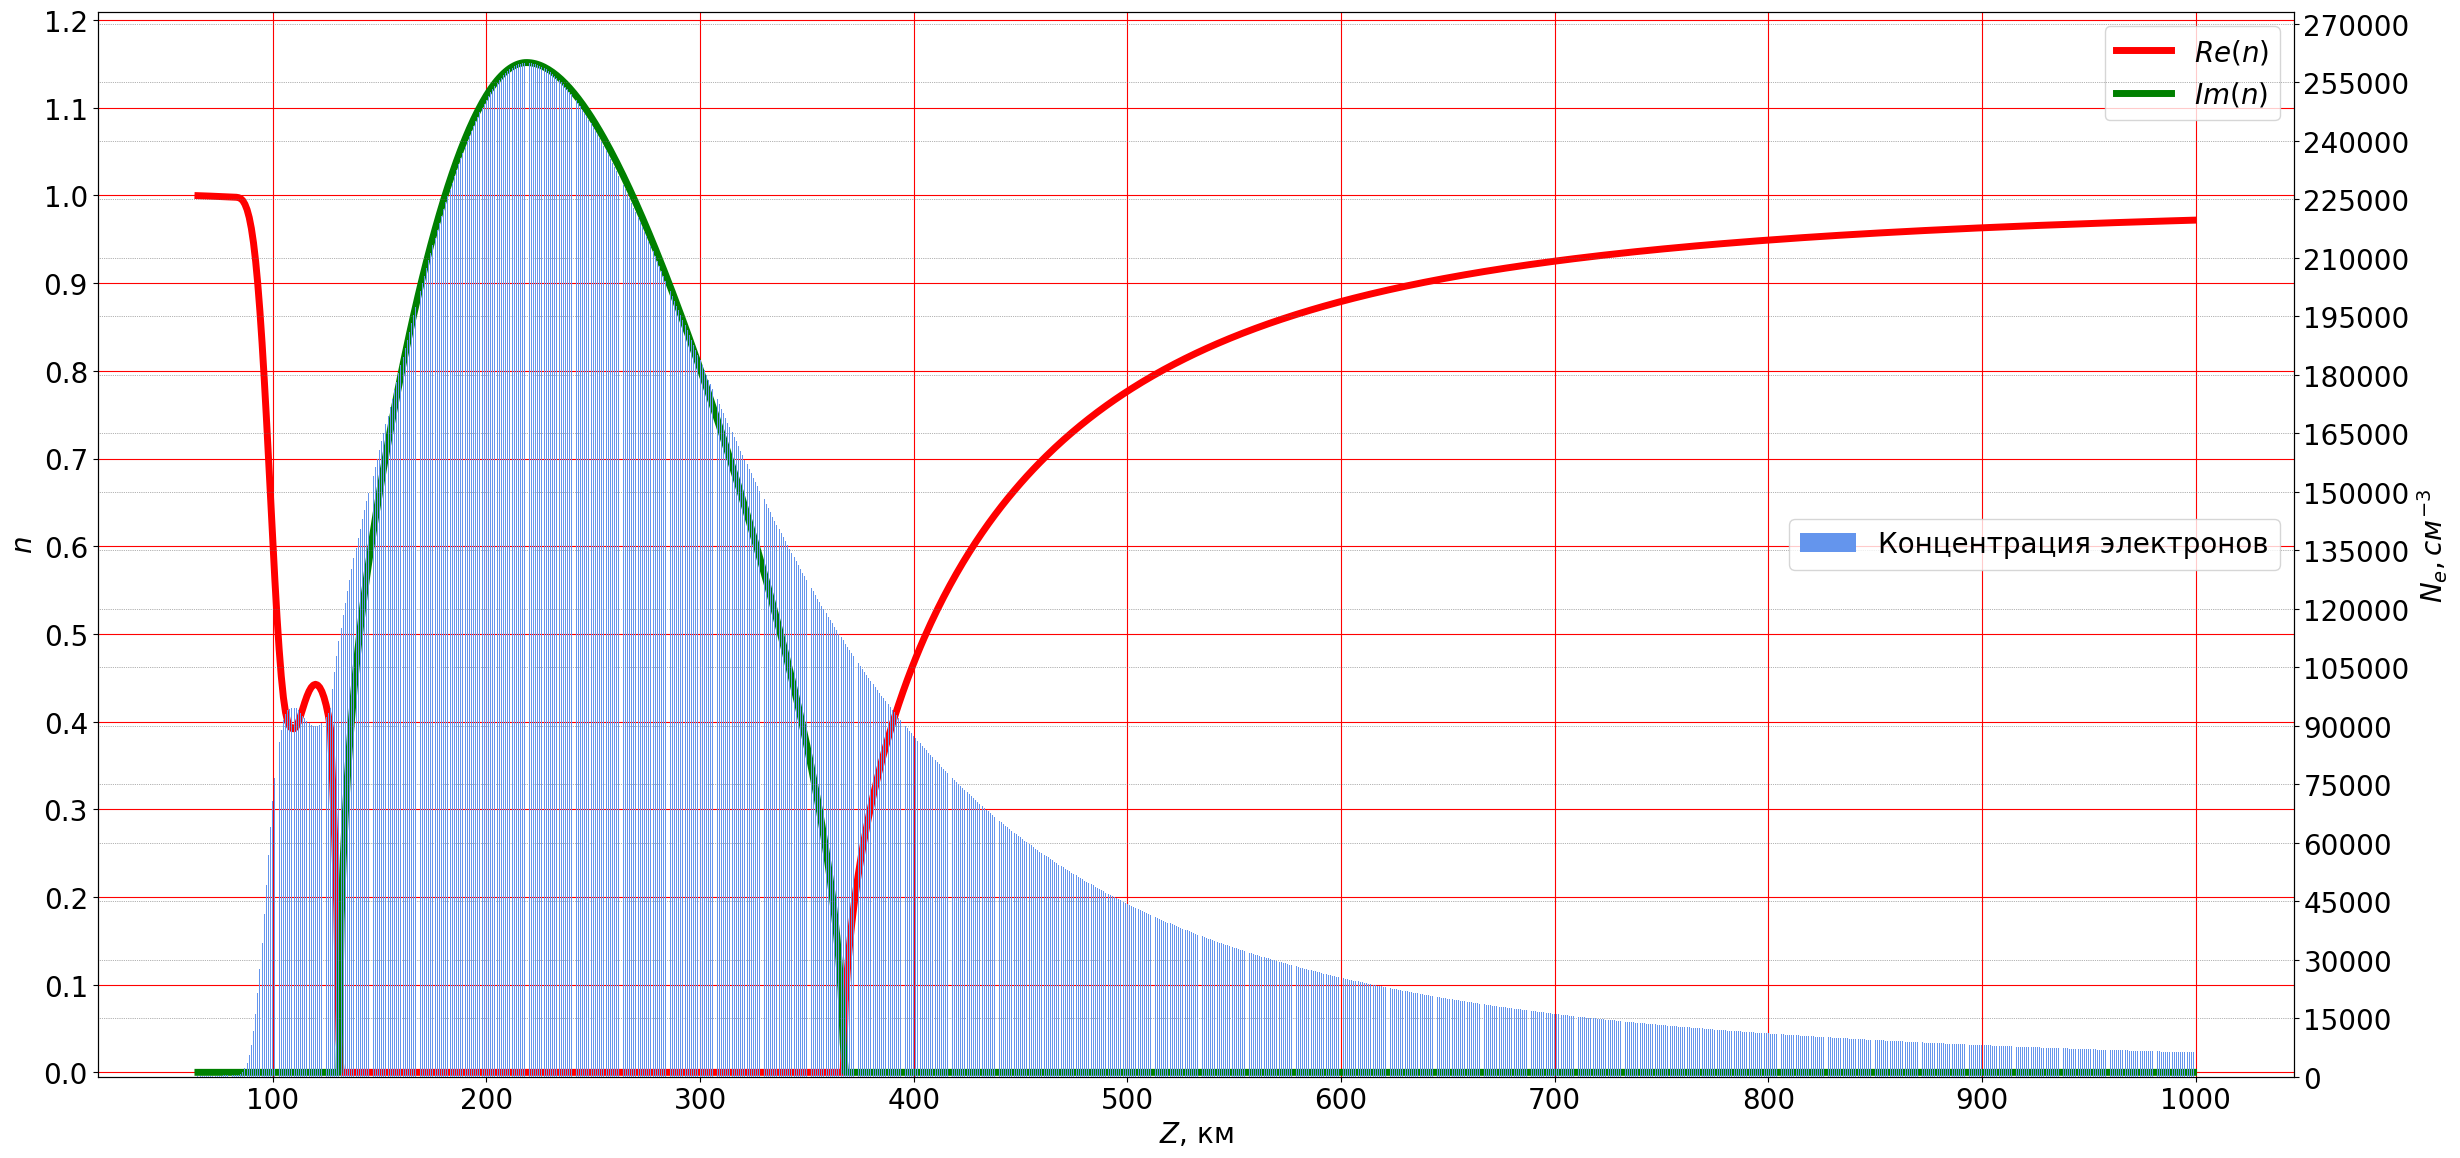

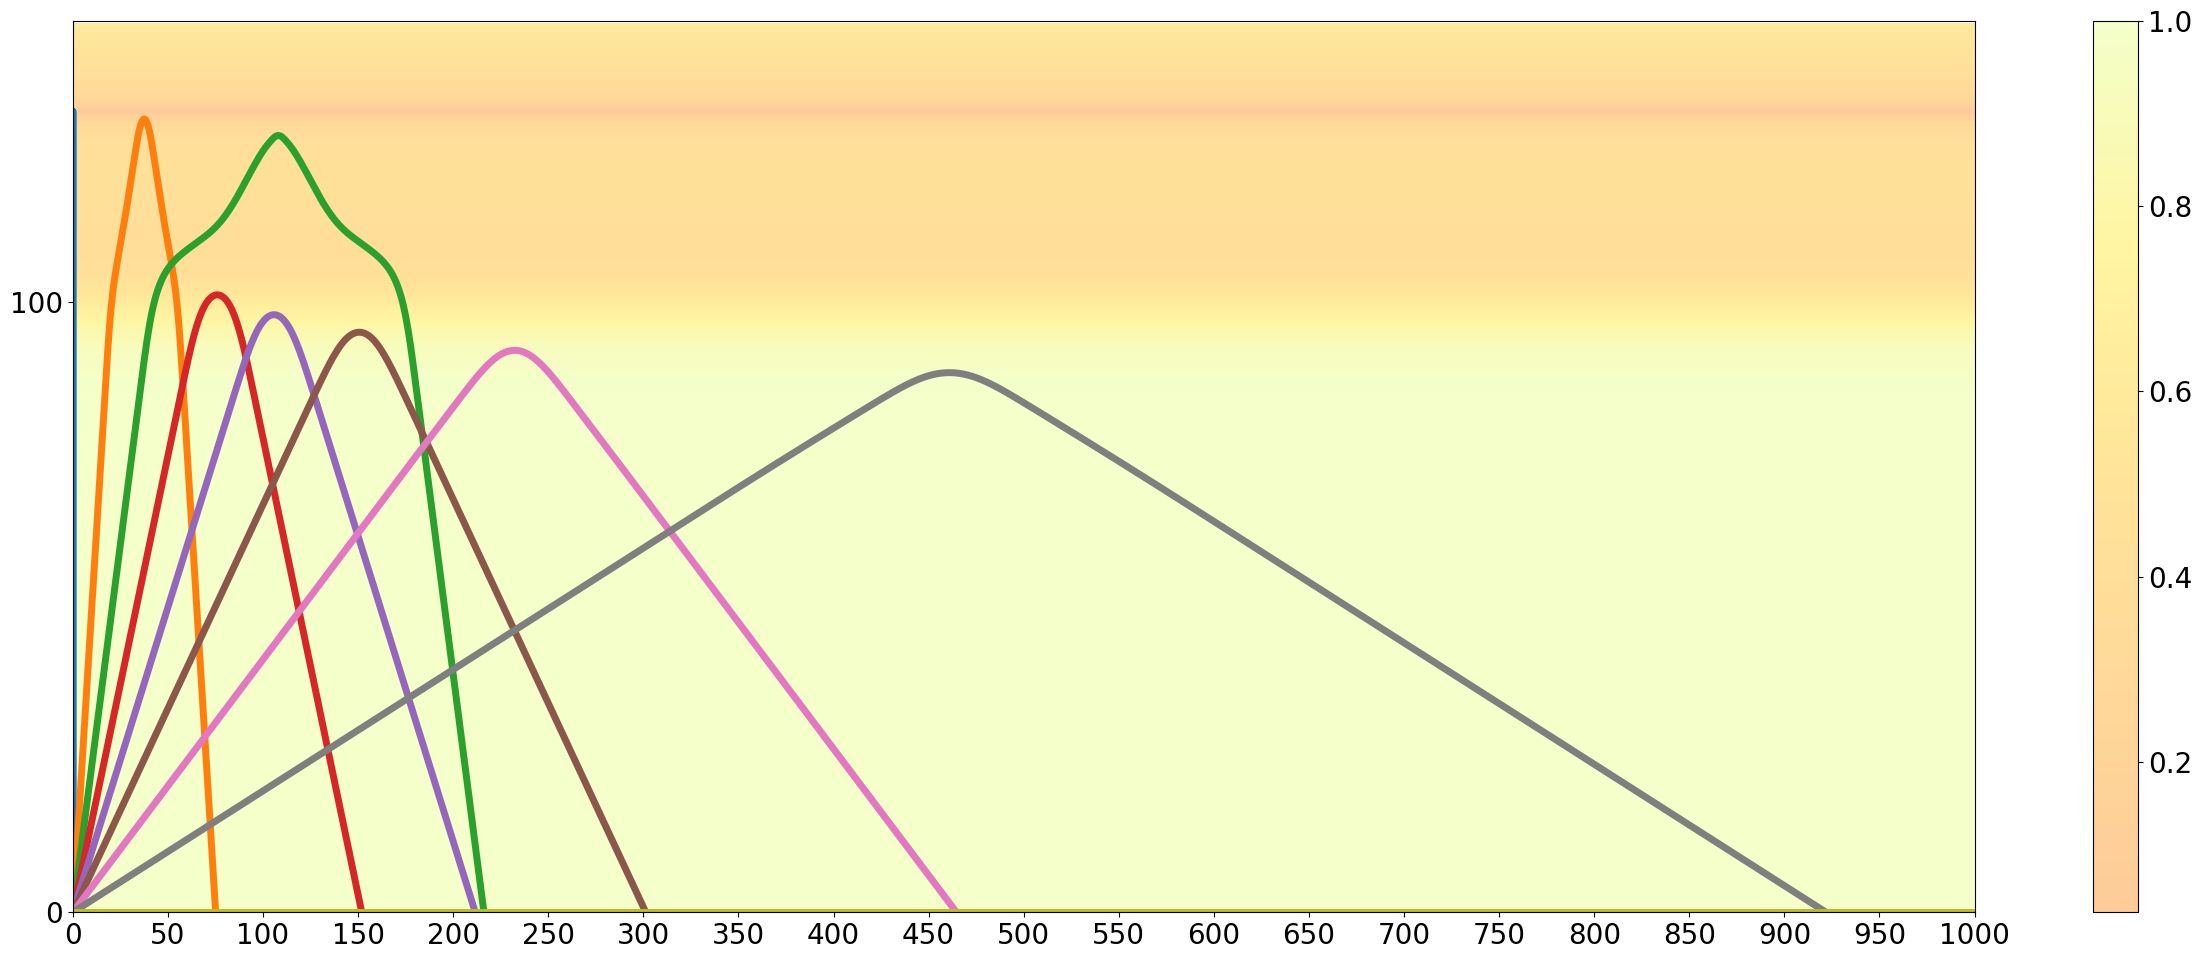

In [12]:
omega, omega_plasm, n_quad, n, interpol_n, n_for_graph, z, N_e, layers, freq, mode = init_var(3, 'day')
ploting_n_distibution(n, N_e, freq=freq, mode=mode)
calculating(np.linspace(0, pi/2, 9), freq, interpol_n, n_for_graph, layers, mode, colors = False, background = True, layers_mode = False)

  0%|                                                                         | 0/9 [00:00<?, ?it/s]C:\Users\astro\AppData\Local\Temp\ipykernel_11372\3966948092.py:4: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d = 0.5 * derivative(lambda z: n(z)**2, z, dx=1, n=1)
100%|█████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.61s/it]


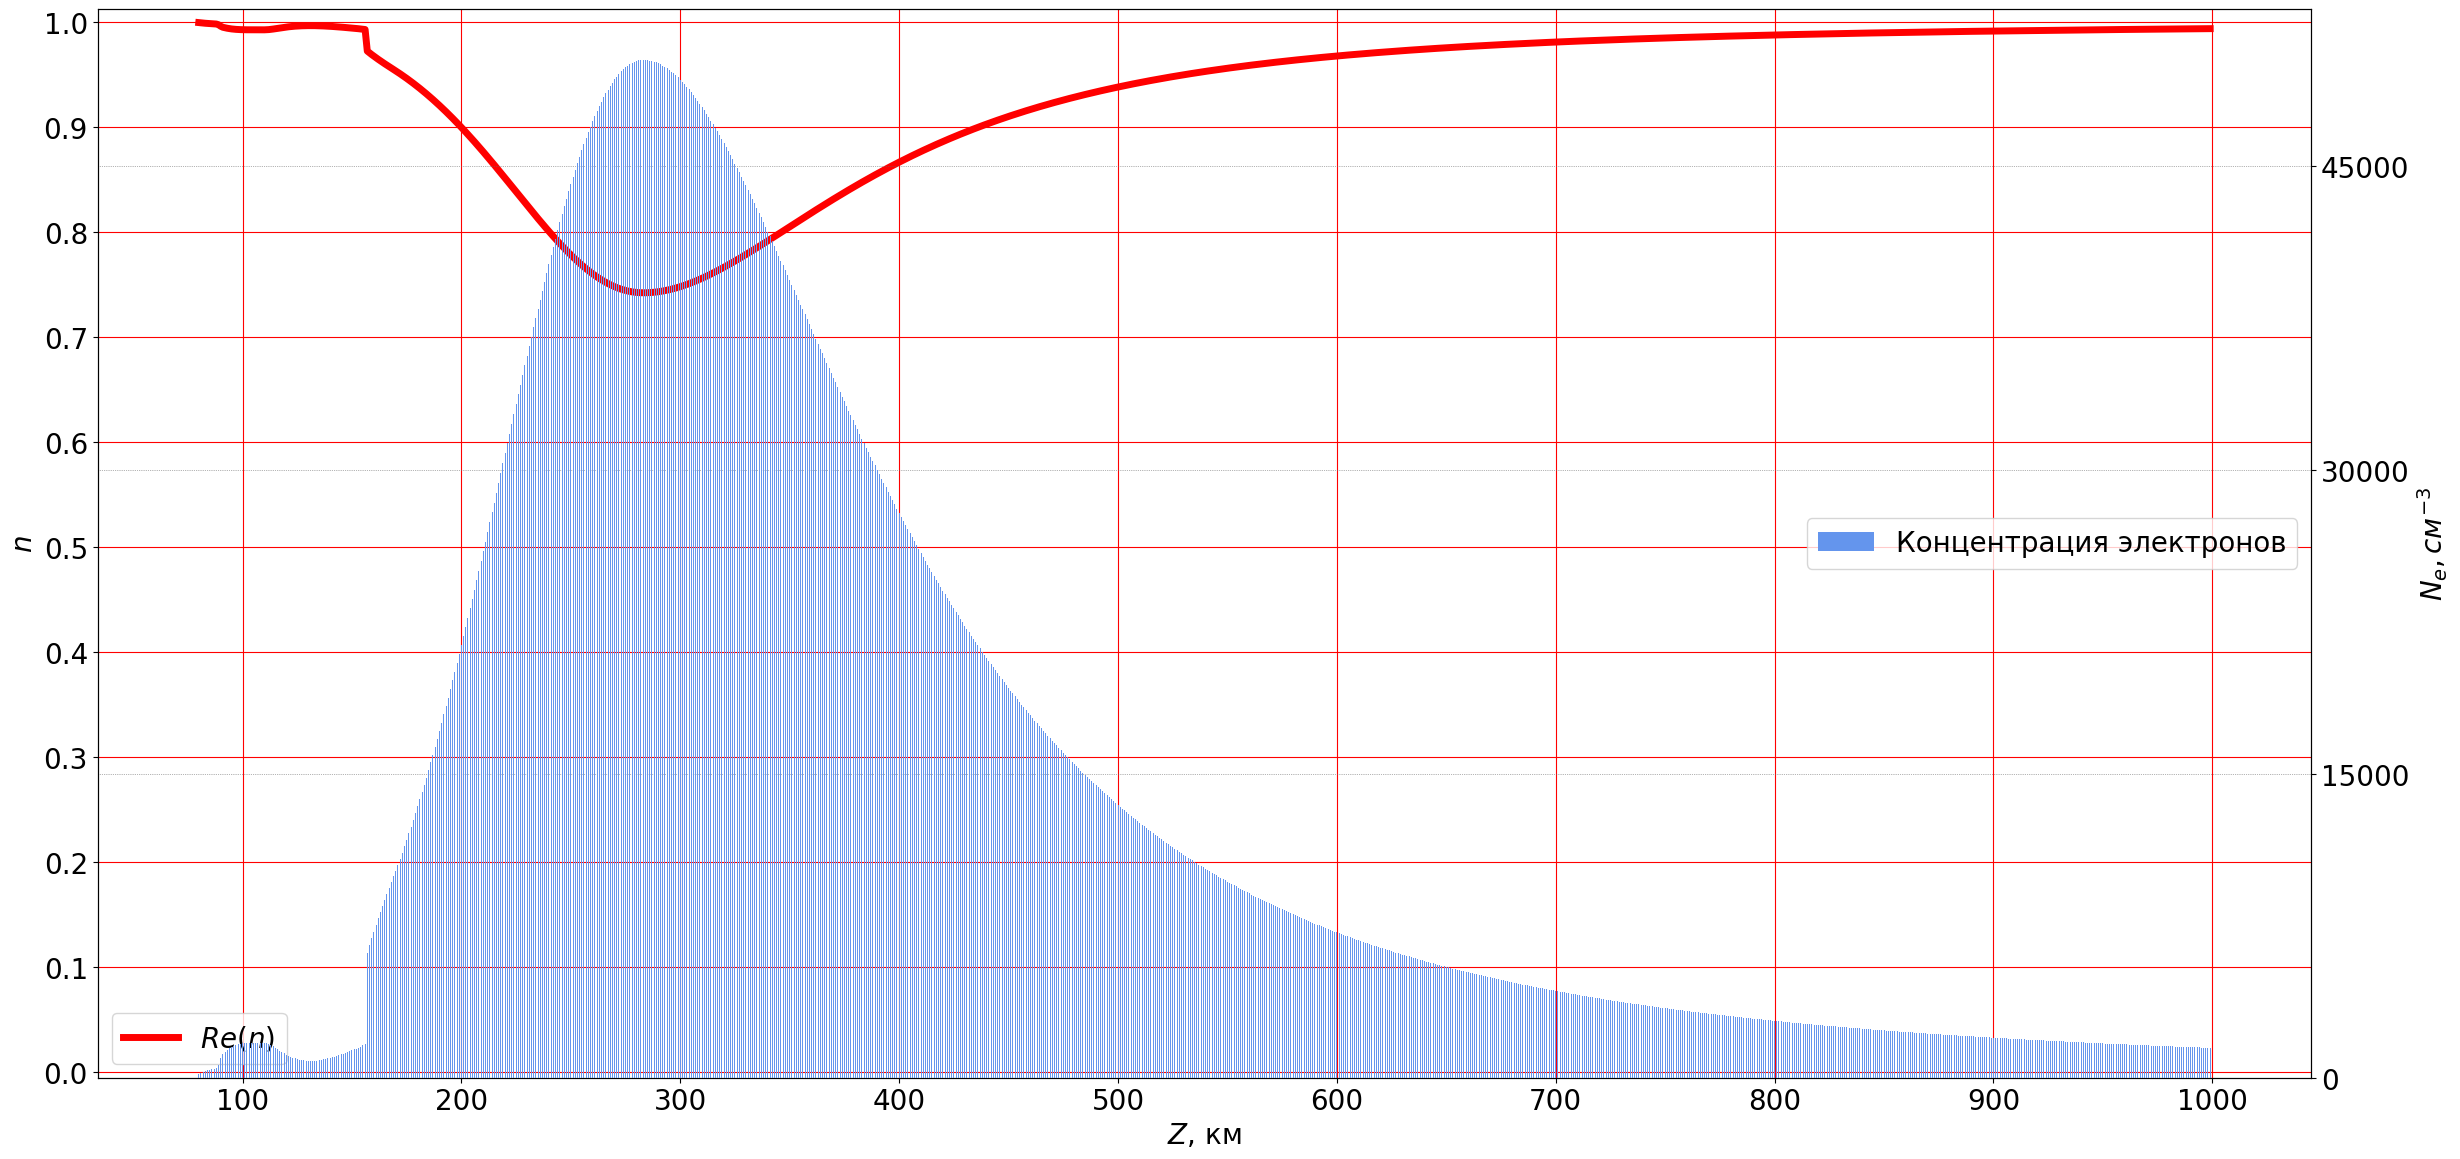

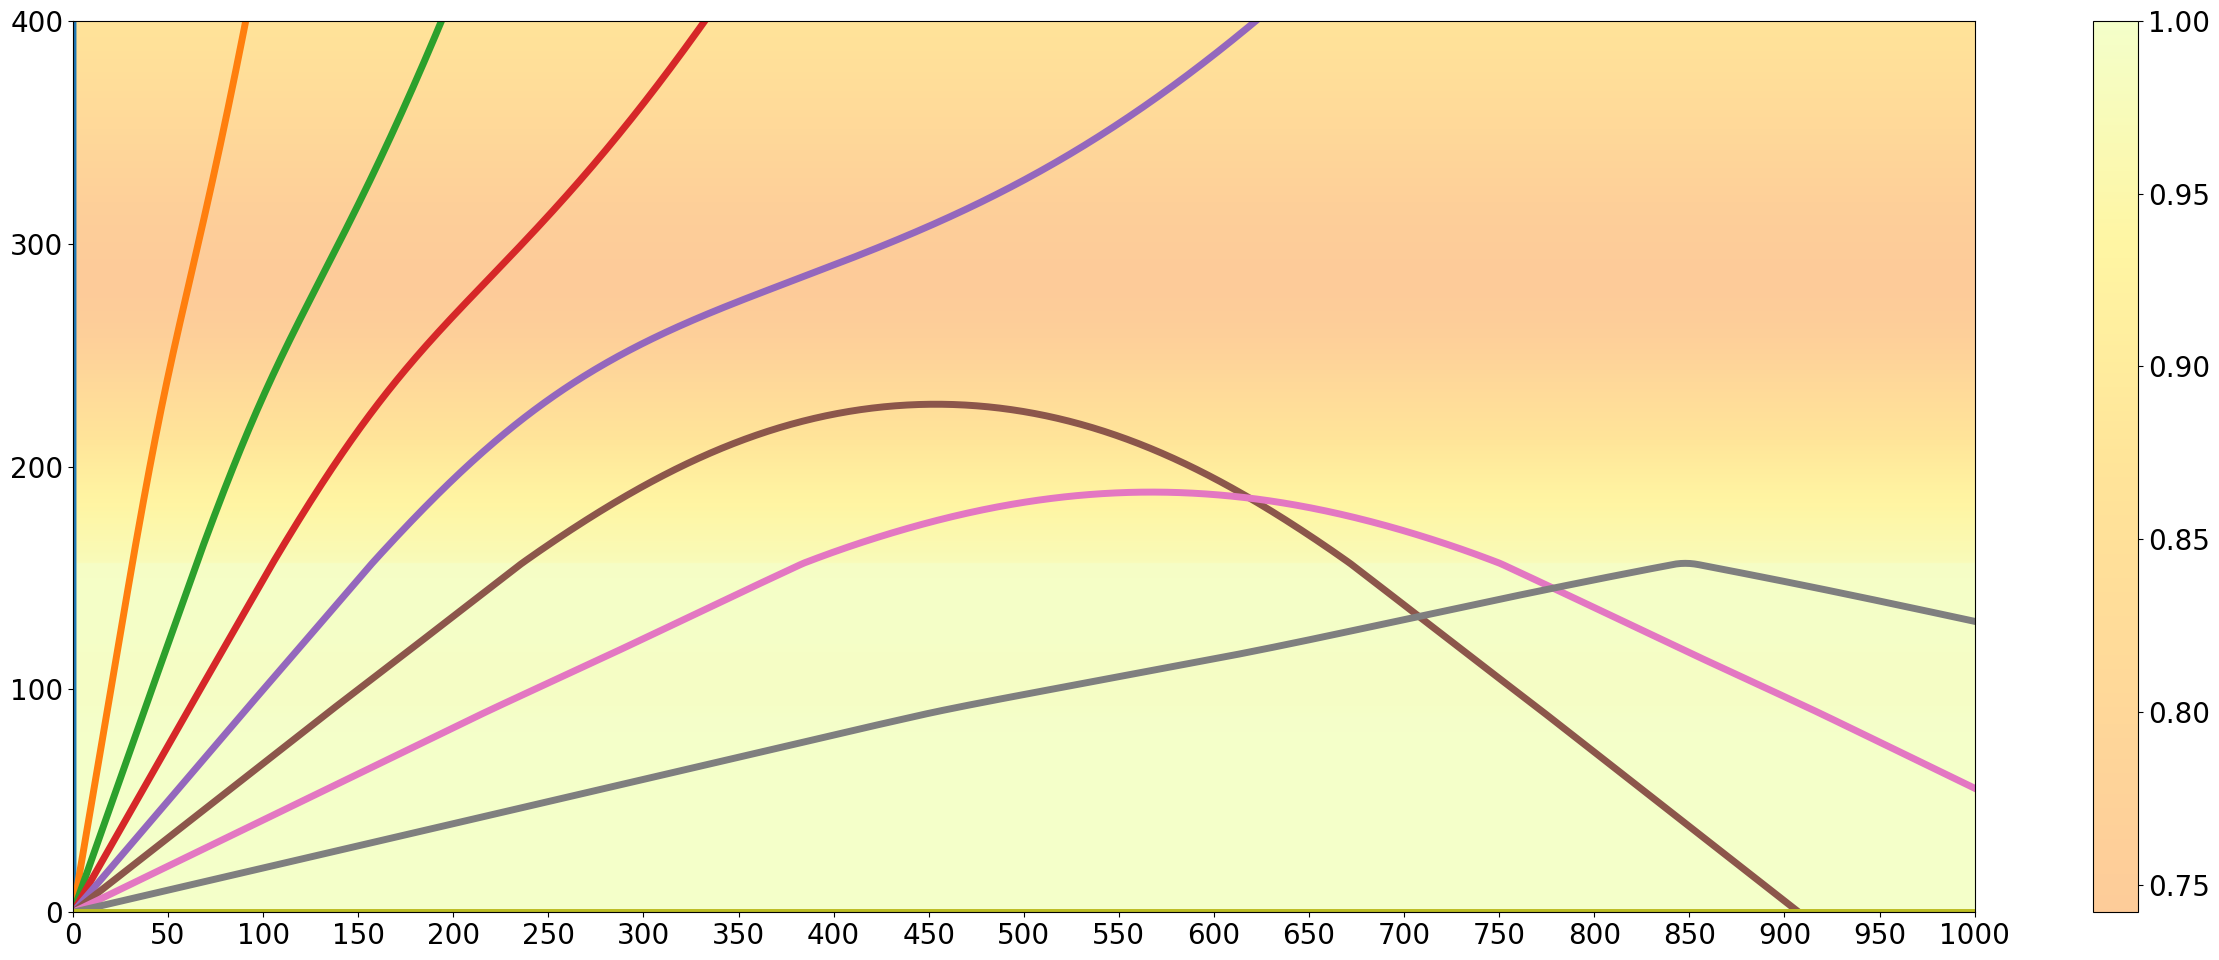

In [13]:
omega, omega_plasm, n_quad, n, interpol_n, n_for_graph, z, N_e, layers, freq, mode = init_var(3, 'night')
ploting_n_distibution(n, N_e, freq=freq, mode=mode)
calculating(np.linspace(0, pi/2, 9), freq, interpol_n, n_for_graph, layers, mode, colors = False, background = True, layers_mode = False)

  0%|                                                                         | 0/9 [00:00<?, ?it/s]C:\Users\astro\AppData\Local\Temp\ipykernel_11372\3966948092.py:4: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d = 0.5 * derivative(lambda z: n(z)**2, z, dx=1, n=1)
100%|█████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.57s/it]


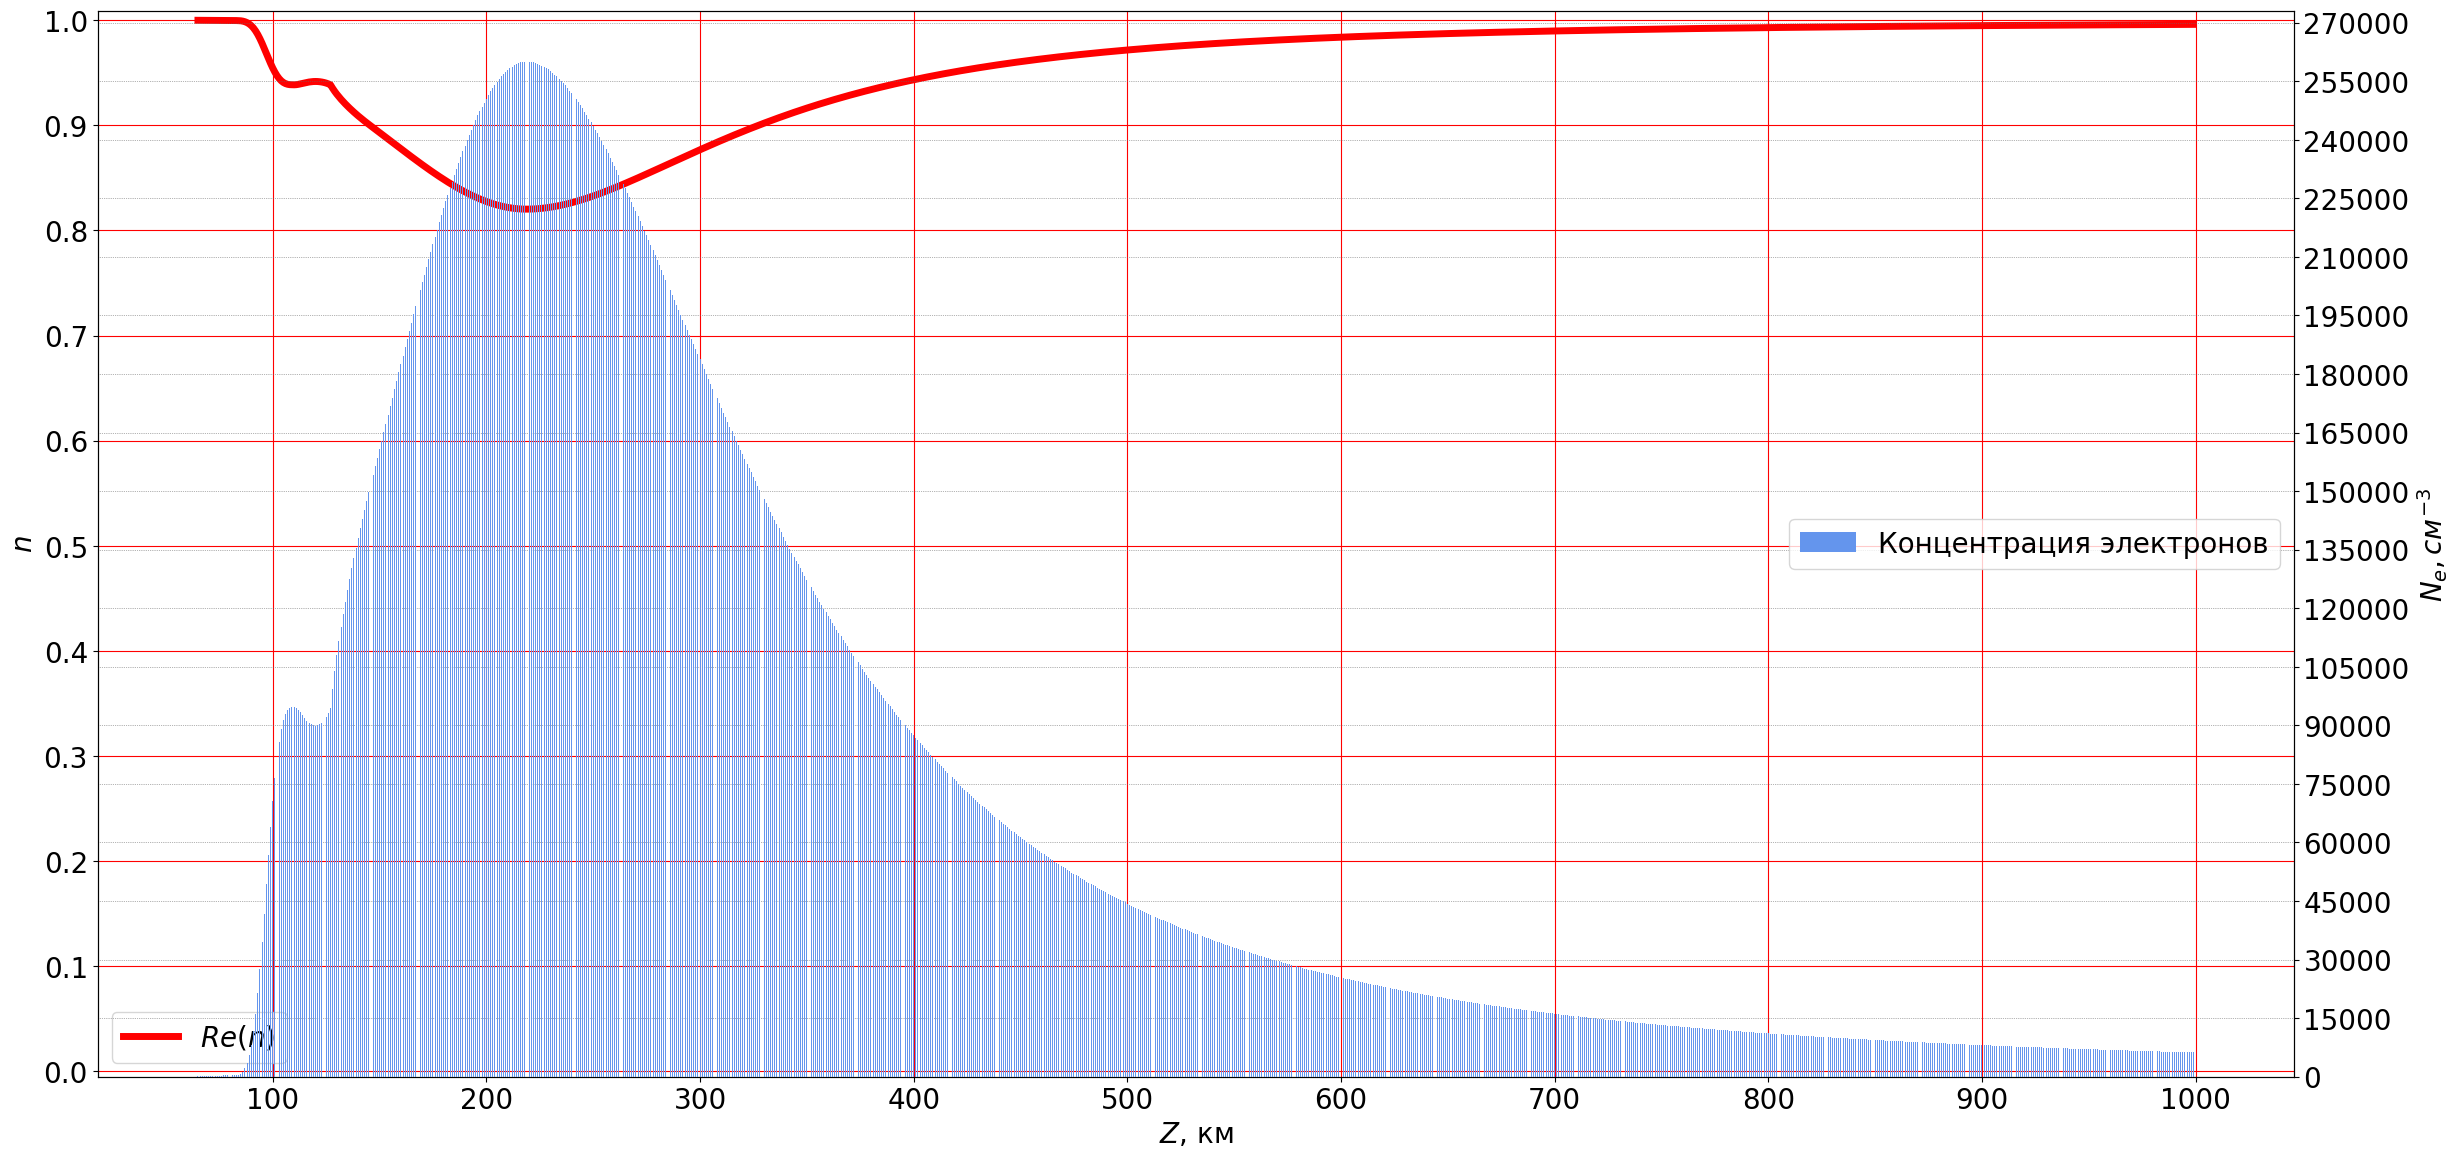

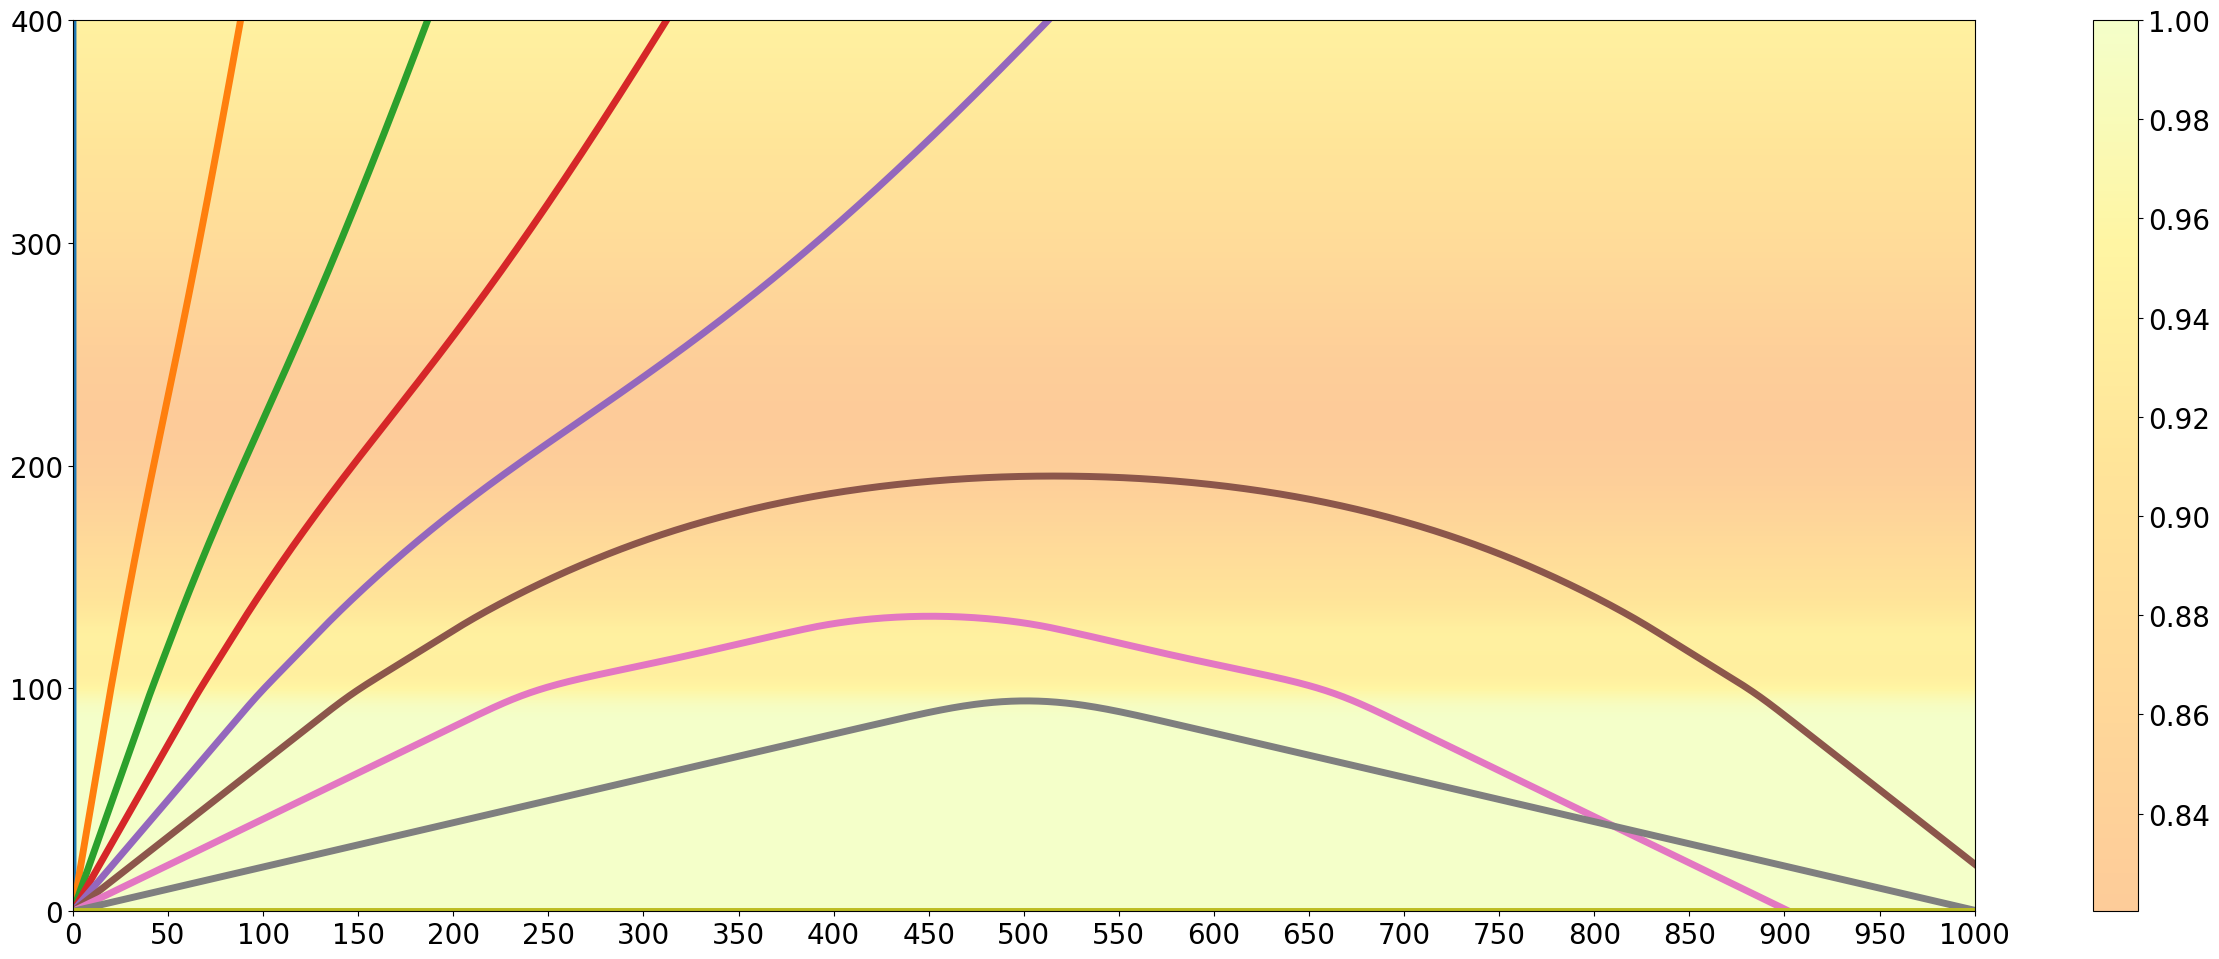

In [14]:
omega, omega_plasm, n_quad, n, interpol_n, n_for_graph, z, N_e, layers, freq, mode = init_var(8, 'day')
ploting_n_distibution(n, N_e, freq=freq, mode=mode)
calculating(np.linspace(0, pi/2, 9), freq, interpol_n, n_for_graph, layers, mode, colors = False, background = True, layers_mode = False)

  0%|                                                                         | 0/9 [00:00<?, ?it/s]C:\Users\astro\AppData\Local\Temp\ipykernel_11372\3966948092.py:4: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d = 0.5 * derivative(lambda z: n(z)**2, z, dx=1, n=1)
100%|█████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.73s/it]


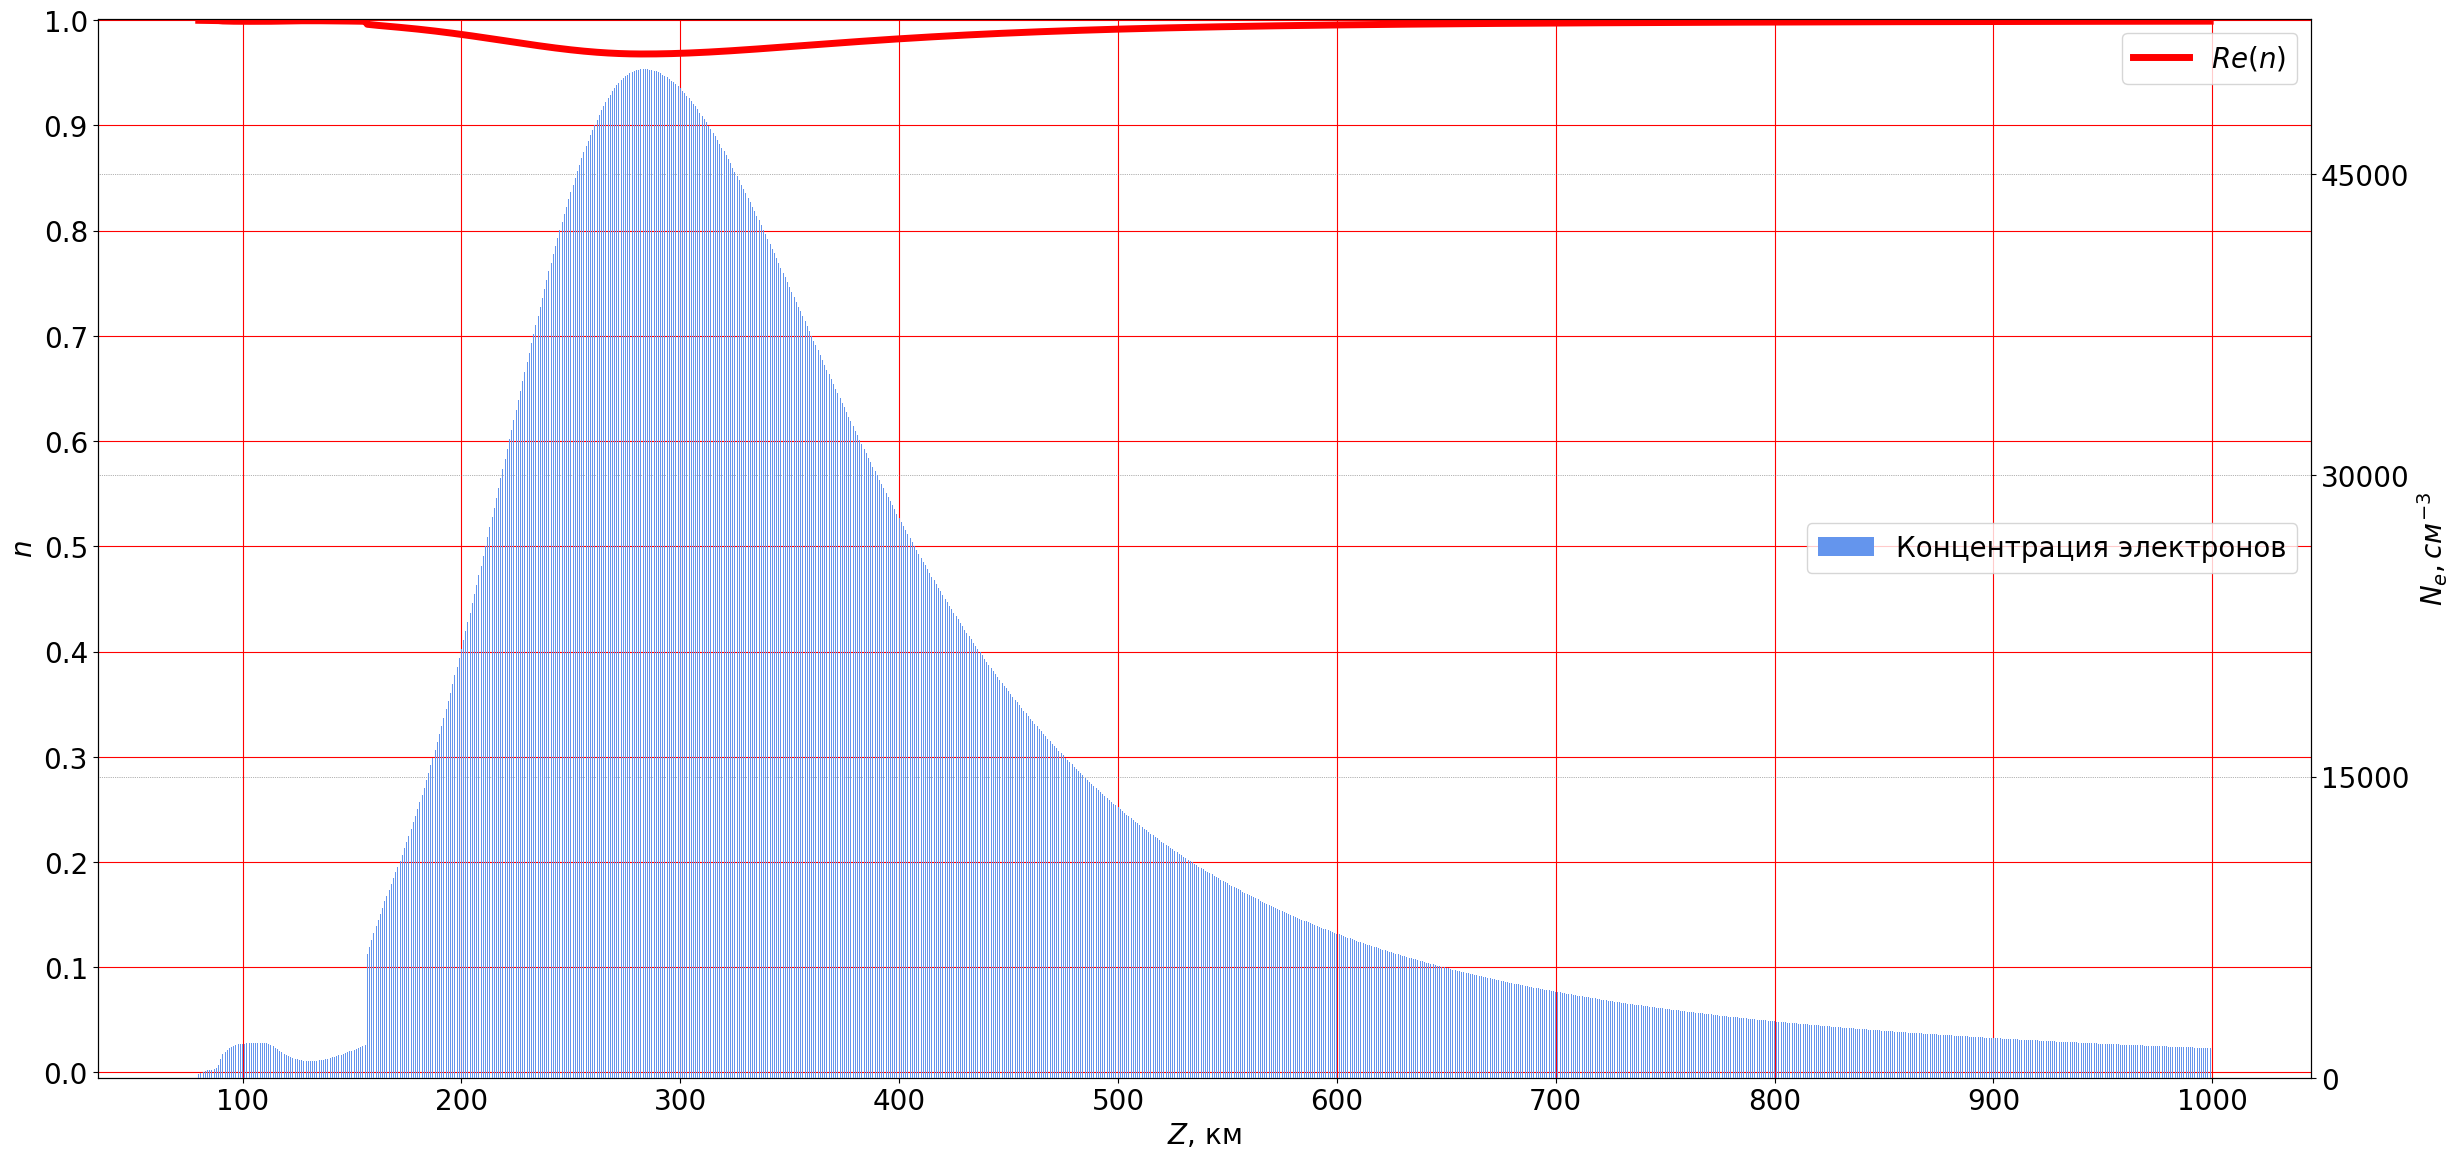

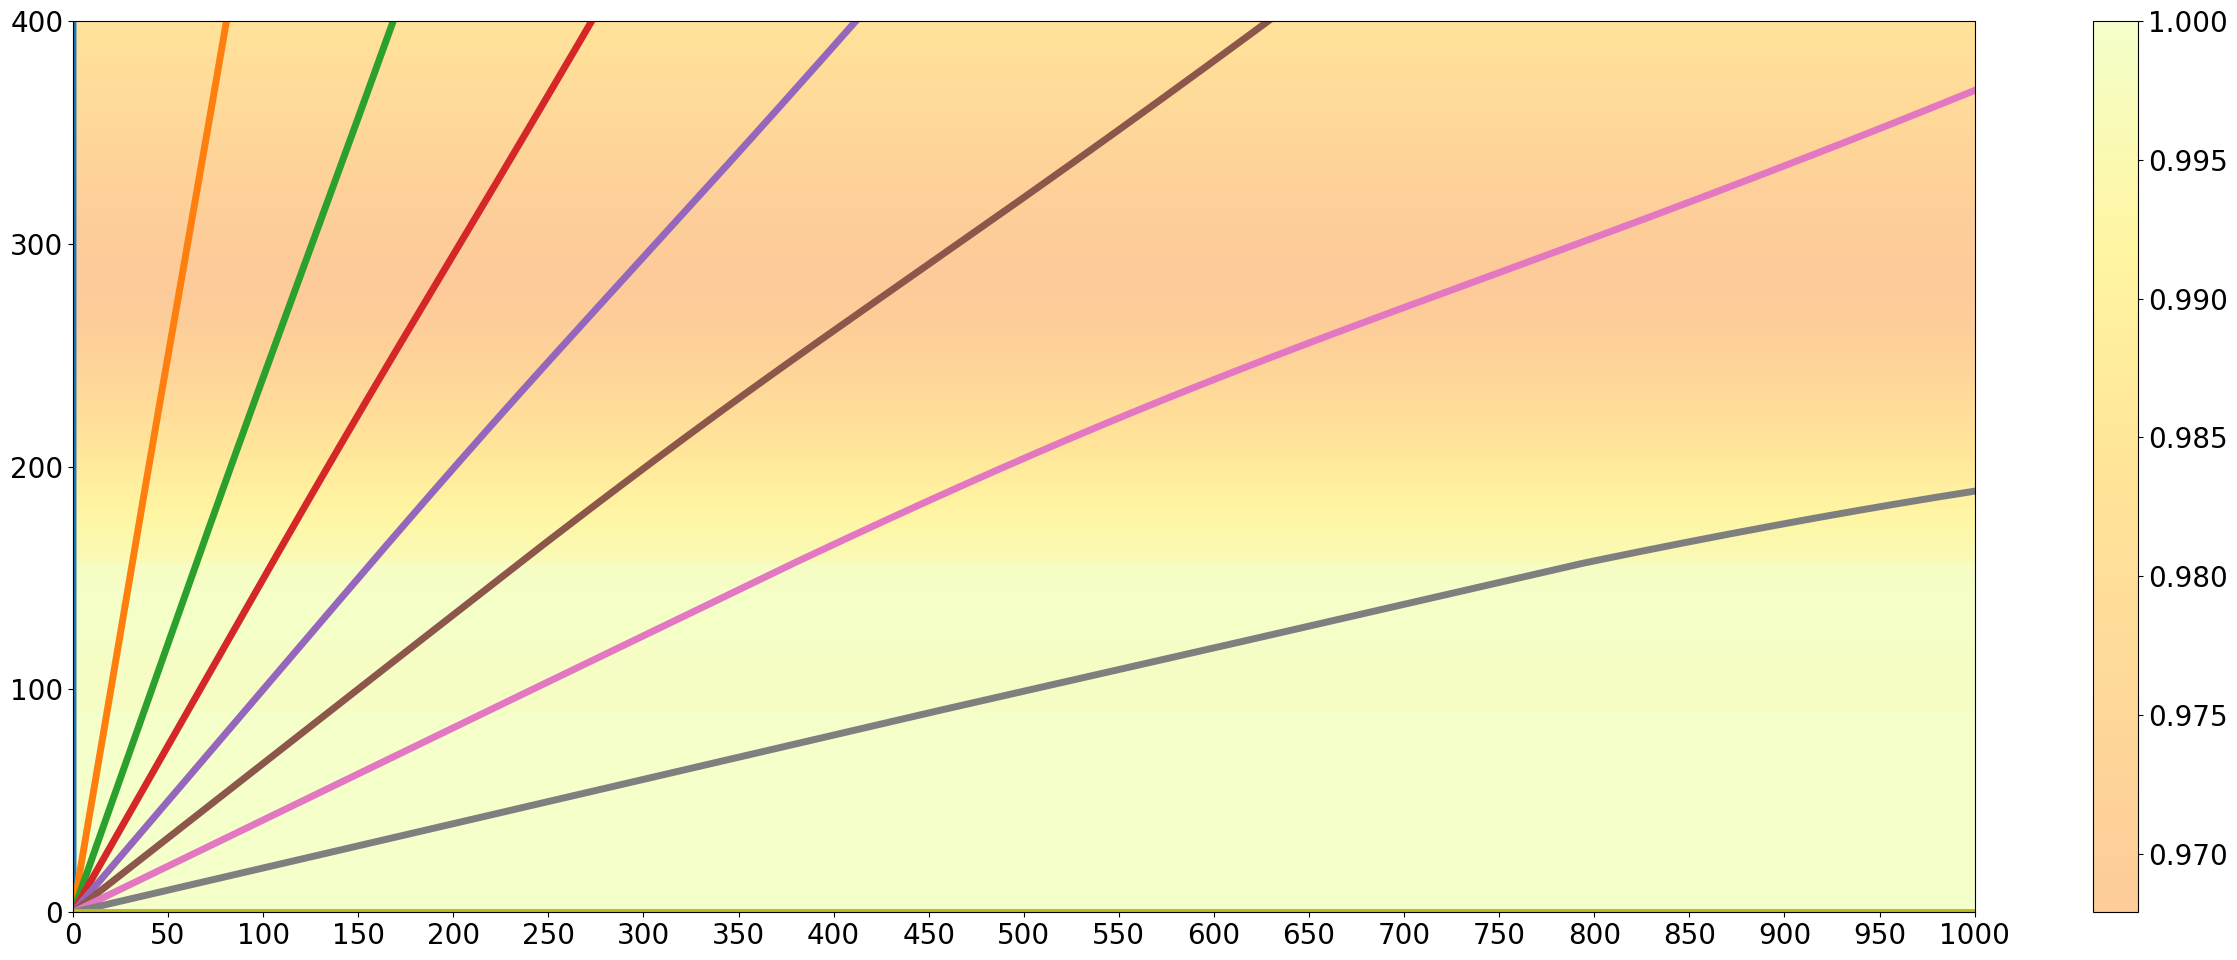

In [15]:
omega, omega_plasm, n_quad, n, interpol_n, n_for_graph, z, N_e, layers, freq, mode = init_var(8, 'night')
ploting_n_distibution(n, N_e, freq=freq, mode=mode)
calculating(np.linspace(0, pi/2, 9), freq, interpol_n, n_for_graph, layers, mode, colors = False, background = True, layers_mode = False)